In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from math import sqrt

## Data Preparation

In [2]:
#import salary dataset, removing NAs
df = pd.read_csv("salary.csv")
df = df.dropna()

df.Field = df.Field.astype('category')

#create dummy variables of Field, the only categorical variable
pd.get_dummies(df, drop_first=True)

#we'll assume that you looked at the distribution of variables and their relationships 
#in the previous assignment, as well as missing values and potential outliers

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,yearsabs,Field_2,Field_3,Field_4
0,53000.0,0,0,0,1.17,1,0,1,1,0,0,1,0
1,58000.0,1,0,0,1.24,1,0,1,1,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,1,2,0,1,0
3,35782.0,0,2,1,0.99,1,0,1,1,1,0,0,1
4,34731.0,0,2,2,0.91,1,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,2,0,70,1,0,0
510,60402.0,6,19,7,0.86,1,0,3,0,72,0,0,0
511,53187.0,19,7,6,0.78,1,0,3,0,76,0,0,1
512,56542.0,8,20,10,0.78,1,0,3,0,78,1,0,0


mean : 0.0, st dev: 1.0


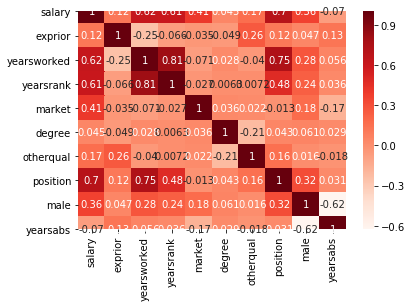

In [4]:
#visually show high correlation between yearsworked and yearsrank
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

#select two feature sets
x1 = df.drop(columns=['salary'])
x2 = df.drop(columns=['salary', 'yearsrank']) #without yearsrank

y = df['salary']

#standardise data so that mean=0 and SD=1    
standardizer = StandardScaler()   
x1_scaled = standardizer.fit_transform(x1)
x2_scaled = standardizer.fit_transform(x2)

#test that it worked
print(f"mean : {round(np.mean(x1_scaled), 2)}, st dev: {round(np.std(x1_scaled),2)}")

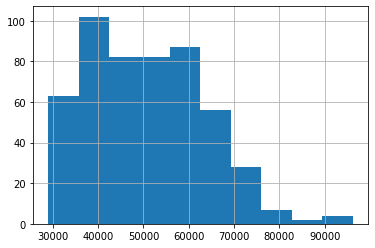

In [5]:
y.hist();

The distribution is skewed - log transform to correct.

In [6]:
#transform y variable so that it is normally distributed. We will use this variable as the outcome
y_log = y.apply(np.log)

In [7]:
#do test-train split
x1train, x1test, ytrain, ytest = train_test_split(x1_scaled, y_log, test_size = 0.2, random_state = 2)

#check that it worked
print("Train and test data shapes:")
datasets = [x1train, x1test, ytrain, ytest]
for df in datasets:
    print(df.shape)

Train and test data shapes:
(410, 10)
(103, 10)
(410,)
(103,)


## Model 1: The full regression model

In [31]:
# run regression
lr = LinearRegression()

#model with years_rank
model1 = lr.fit(x1train,ytrain)

#model outputs
print(f'Intercept: {model1.intercept_}\n')
print(f'Coefficients: {model1.coef_}\n')

#get %variance in y explained by the variance in the features
def get_rsquared(model, xtrain, xtest):
    r_squared = model.score(xtrain,ytrain)
    print(f"r2: {round(r_squared,2)}")

get_rsquared(model1, x1train, ytrain)  

Intercept: 10.808696238883723

Coefficients: [ 0.014508   -0.00711911  0.08092304  0.10081632  0.00092358  0.00741048
  0.13201848  0.00897059 -0.0413046   0.00342296]

r2: 0.83


In [34]:
#with k-fold cross-validation
#split the data into five and get the mean r_squared value from the groups
kf = KFold(n_splits = 5, random_state = 600)
rsquared_kfold = cross_val_score(model1, x2train, ytrain, cv=kf)
rsquared_mean = round(rsquared_kfold.mean(),2)
rsquared_2SD = round(rsquared_kfold.std()*2, 2)
print(f"Ave. proportion of variance explained over folds: {rsquared_mean} (+/-{rsquared_2SD})") 

Ave. proportion of variance explained over folds: 0.79 (+/-0.07)


In [33]:
#get metrics
y_pred_model1 = model1.predict(x1test)

#Mean Squared Error
mse_model1 = metrics.mean_squared_error(ytest, y_pred_model1)
print("MSE:", round(mse_model1, 2))

#Root Mean Sqared Error
rmse_model1 = sqrt(mse_model1)
print("RMSE:", round(rmse_model1, 2))

MSE: 0.01
RMSE: 0.11


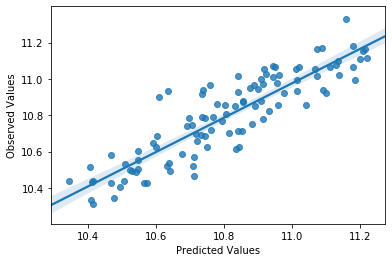

In [13]:
ax = sns.regplot(y_pred_model1, ytest)
ax.set(xlabel = 'Predicted Values', ylabel = 'Observed Values');

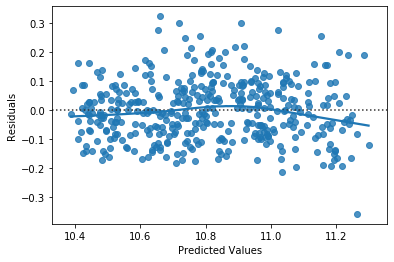

In [14]:
def residplot(model,x,y,**kwargs):
    '''
    This function plots a regular residual plot
    Inputs:
        model = Trained sklearn model
        X: Predictors as a pandas dataframe
        y: Responses as a pandas dataframe
        kwargs: seaborn.residplot arguments
    Output:
        Matplotlib axes
    '''
    vals = {'Residuals': y - model.predict(x), 'Predicted Values': model.predict(x)}
    resdf = pd.DataFrame(vals)
    ax = sns.residplot(y='Residuals',x='Predicted Values', data=resdf, **kwargs)
    
    return ax
 
residplot(lr,x1train,ytrain, lowess = True);

In [42]:
#Optional: Do the regression using statsmodels to get outliers and influential values easily

#Fit linear model to any dataset
x1train_plusconstant = sm.add_constant(x1train)
lr_statsmodels = sm.OLS(ytrain,x1train_plusconstant)
model1_statsmodels = lr_statsmodels.fit()

#create instance of influence
influence = model1_statsmodels.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

#studentized residuals
studentized_residuals = influence.resid_studentized_external

print("\nOutliers and Influential Values\n")
print(f"Max leverage: {np.max(leverage)}")
print(f"Max cooks_d: {np.max(cooks_d)}")
print(f"standardized_residuals between {np.min(standardized_residuals)} and {np.max(standardized_residuals)}")

## Model 2: No `yearsrank`
Do the same thing for the second model, leaving out years worked at current rank as a predictor

In [17]:
#data preparation
x2train, x2test, ytrain, ytest = train_test_split(x2_scaled, y_log, test_size = 0.2, random_state = 2)

#check that it worked
datasets = [x2train, x2test, ytrain, ytest]
print("Train and test data shapes:")
for df in datasets:
    print(df.shape)

Train and test data shapes:
(410, 9)
(103, 9)
(410,)
(103,)


In [19]:
#build model
model2 = lr.fit(x2train,ytrain)
#get predictions
y_pred_model2 = model2.predict(x2test)

get_rsquared(model2, x2train, x2test)

#Mean Squared Error & RMSE
mse_model2 = metrics.mean_squared_error(ytest, y_pred_model2)
print("MSE:", round(mse_model2,2))
rmse_model2 = sqrt(mse_model2)
print("RMSE:", round(rmse_model2,2))

r2: 0.81
MSE: 0.01
RMSE: 0.12


The model performs similarly on the test data - the RMSE and MSE values are only sligthly higher (indicating slightly more error) and the variance explained is similar. There is no need to use `yearsrank` as a feature.Let's look at model diagnostics.

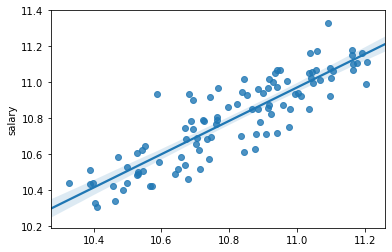

In [21]:
sns.regplot(y_pred_model2, ytest);

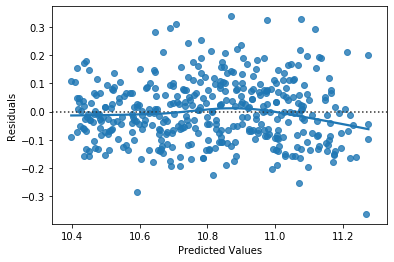

In [22]:
residplot(lr,x2train,ytrain, lowess = True);

The residuals are still non-linear: we can try to make this model better. However, there doesn't seem to be a big difference between the model with and without `yearsrank` - we can leave it out.

In [28]:
#with k-fold cross-validation
from sklearn.model_selection import KFold, cross_val_score

#split the data into five and get the mean r_squared value from the groups
kf = KFold(n_splits = 5, random_state = 600)
rsquared_kfold = cross_val_score(lr, x2train, ytrain, cv=kf)
rsquared_mean = round(rsquared_kfold.mean(),2)
rsquared_2SD = round(rsquared_kfold.std()*2, 2)
print(f"Variance explained: {rsquared_mean} (+/-{rsquared_2SD})") 


Variance explained: 0.79 (+/-0.07)


## Your assignment

This notebook contains the information we need, but could be easier to read and more DRY. Make classes for the regression steps, plus a workflow class to make the code easier to read.